In [1]:
import pandas as pd
from collections import Counter
import spacy
from spacymoji import Emoji
from spacy_ngram import NgramComponent
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('HateBR.csv')
df.head()

,id,comentario,anotator1,anotator2,anotator3,label_final,links_post,account_post
0,1,Mais um lixo,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
1,2,Essa nao tem vergonha na cara!!,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
2,3,Essa mulher é doente.pilantra!,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
3,4,Comunista safada...,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
4,5,Vagabunda. Comunista. Mentirosa. O povo chilen...,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli


In [3]:
# mark end of sentence in every line
df['comentario'] = df['comentario'].apply(lambda x: x.strip() + '.' if not x.strip().endswith(('.', '?', '!')) else x.strip())


In [4]:
all_text = " ".join(df['comentario'].astype(str).tolist())
all_text[:500]

'Mais um lixo. Essa nao tem vergonha na cara!! Essa mulher é doente.pilantra! Comunista safada... Vagabunda. Comunista. Mentirosa. O povo chileno nao merece uma desgraça desta. COMUNISTA SAFADA, MALPARIDA, MAMAGUEVA, DESGRAÇADA, COÑO É TU MADRE. Besta quadrada. Se elegeu as nossas custas. Comunista lixo! Quem tem pena é galinha, mas ela é uma VACA LOUCA. Mande essa Bachelet plantar batata no asfalto. Puta que pariu até o tamborete de bordel se acha no direito de falar do Brasil. Mulherzinha safad'

In [5]:
# delete multiple terminal punctations
# without this step: num of sentences = 13771
endings = ['.', '!', '?']
idx = 0
while idx < len(all_text) - 1:
    if all_text[idx] in endings and all_text[idx + 1] in endings:
        all_text = all_text[:idx + 1] + all_text[idx + 2:]
    else:
        idx += 1

print(all_text)


Mais um lixo. Essa nao tem vergonha na cara! Essa mulher é doente.pilantra! Comunista safada. Vagabunda. Comunista. Mentirosa. O povo chileno nao merece uma desgraça desta. COMUNISTA SAFADA, MALPARIDA, MAMAGUEVA, DESGRAÇADA, COÑO É TU MADRE. Besta quadrada. Se elegeu as nossas custas. Comunista lixo! Quem tem pena é galinha, mas ela é uma VACA LOUCA. Mande essa Bachelet plantar batata no asfalto. Puta que pariu até o tamborete de bordel se acha no direito de falar do Brasil. Mulherzinha safada. Oportunista essa corrupta.Agora todos os Comunistas querem se fazer de vítimas. Porque é uma bandida. Mentem e roubam. Não vai mais mamar. Tudo igual. Só pensam no próprio rabo. Plano da esquerda foi é e será sempre críticar não nunca teve um plano de governo único plano era como roubar . Guarde sua "pena" .nos da ânsia de vômito. Quem não têm caráter é contra o presidente Bolsonaro. O problema dela é que a tetinha secou. Será que alguém em sã consciência ainda vai acreditar nesta farsante? Não 

In [6]:
# number of sentences
nlp = spacy.load('pt_core_news_sm')
emoji = Emoji(nlp)
nlp.add_pipe("emoji", first=True)
nlp.add_pipe('spacy-ngram', config={'ngrams': (2, 3, 4)})

doc = nlp(all_text)

In [7]:
num_sents=0
for sent in doc.sents:
    num_sents += 1

print("number of sentences: {}".format(num_sents))

number of sentences: 13290


In [8]:
all_sentences=[]
sents_len_character =[] #with emojis and spaces
sents_len_words = [] # sentence len by words
token_str = [] 
sentence_token = []
word_form_len = []
num_token = 0
num_types = 0
conj_freq = 0

for sent in doc.sents:
    sents_len_character.append(len(str(sent))) #with emojis
    sents_str = []
    sents_t = []

    for t in sent:
        if not (t._.is_emoji or t.is_punct or t.is_space):
            sents_str.append(t.text.lower()) # for list with sents
            sents_t.append(t)
            token_str.append(t.text.lower()) # for list with token_str
            if t.pos_ == 'CONJ' or t.pos_ == 'CCONJ':
                conj_freq += 1
    #sentence = [t.text.lower() for t in sent if not (t._.is_emoji or t.is_punct or t.is_space)] #as str; try to get rid of
    #sentence_t = [t for t in sent if not (t._.is_emoji or t.is_punct or t.is_space)] #as token
    sentence_token.append(sents_t)
    all_sentences.append(sents_str) #?
    sents_len_words.append(len(sents_str))

num_sentences = len(all_sentences)
num_types = len(set(token_str)) # no duplicates
num_token = len(token_str)

# avg sentence length
sents_len_character = sum(sents_len_character)/num_sentences
sents_len_words = sum(sents_len_words)/num_sentences

# word form length
word_form_len = [len(str(t)) for t in token_str]
word_form_len = sum(word_form_len)/num_token

# hapax legomena
ctr = Counter(token_str)
hapax = [token for token, count in ctr.items() if count==1]

# most frequent words
most_common = ctr.most_common(5)

# Zipf
freq_sorted = ctr.most_common()
words, counts = zip(*freq_sorted)

# Erstelle Ränge: 1 = häufigstes Wort, 2 = zweithäufigstes, usw.
ranks = list(range(1, len(counts) + 1))

# most frequent bi-, trigrams,.. (with emojis)
bigrams = doc._.ngram_2
trigrams = doc._.ngram_3
four_grams = doc._.ngram_4


# conjunction frequency
conj_freq /= num_token


print('Number of sentences: '+str(num_sentences))
print('Number of token: '+ str(num_token))
print('Number of types: '+ str(num_types))
print('Avg. sentence length in characters: '+str(sents_len_character))
print('Avg. sentence length in words: '+str(sents_len_words))
print('Avg. word form length: '+str(word_form_len))
print('Number of hapax legomena: '+str(len(hapax)))
print('Most frequent words '+str(most_common))
print('Most frequent n_grams: \n'+
      '- Bigrams: '+str(bigrams[:5])+
      '\n\n- Trigrams: '+str(trigrams[:5])+
      '\n\n- Four_grams: '+str(four_grams[:5]))
print('Conjunction frequency: {0:2.5f}'.format(conj_freq))



Number of sentences: 13290
Number of token: 95614
Number of types: 12514
Avg. sentence length in characters: 42.7033107599699
Avg. sentence length in words: 7.194431903686983
Avg. word form length: 4.7743008346058105
Number of hapax legomena: 7439
Most frequent words [('que', 2829), ('de', 2629), ('o', 2625), ('e', 2415), ('a', 2283)]
Most frequent n_grams: 
- Bigrams: ['lixo_nao', 'nao_vergonha', 'vergonha_cara', 'cara_mulher', 'mulher_doente.pilantra']

- Trigrams: ['lixo_nao_vergonha', 'nao_vergonha_cara', 'vergonha_cara_mulher', 'cara_mulher_doente.pilantra', 'mulher_doente.pilantra_comunista']

- Four_grams: ['lixo_nao_vergonha_cara', 'nao_vergonha_cara_mulher', 'vergonha_cara_mulher_doente.pilantra', 'cara_mulher_doente.pilantra_comunista', 'mulher_doente.pilantra_comunista_safar']
Conjunction frequency: 0.03167


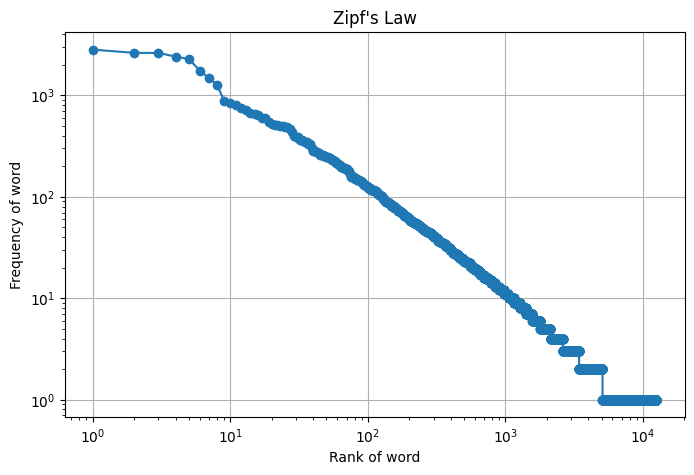

In [9]:
#plot zipf
plt.figure(figsize=(8,5))
plt.loglog(ranks, counts, marker="o")
plt.xlabel("Rank of word")
plt.ylabel("Frequency of word")
plt.title("Zipf's Law")
plt.grid(True)
plt.show()

#### type token ratio:
- varies depending on corpus lenght!
- differ also because of the type of corpus (social media comments vs. books)..

In [10]:
TTR = num_types/num_token
print('{0:2.5f}'.format(TTR))

0.13088
